In [13]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
%run helpers_preproc.ipynb
#added test

In [14]:
#read in the data, get normalized adjacency (NxN)
mesh_dir = 'SHREC11/'
label_np = np.array(readLbl(mesh_dir+'labels.txt'))

In [15]:
node_sigs_list = []
normed_adjMats_list = []

for i in range(600):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    #node level signal extraction
    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)
    node_neigh_sum = np.sum(adj_scaled,axis = 0)
    node_neigh_mean = np.sum(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min,node_neigh_sum,node_neigh_mean],axis = 1)
    
    node_sigs_list.append(node_sig)
    normed_adjMats_list.append(adj_normalized)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_55890/4236562072.py:16: RuntimeWarning: invalid value encountered in divide
  adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])


In [16]:
normed_adjMats = np.nan_to_num(np.stack(normed_adjMats_list))
node_sigs = np.nan_to_num(np.stack(node_sigs_list))

In [17]:
normed_adjMats_tr = normed_adjMats[:450,:,:]
node_sigs_tr = node_sigs[:450,:,:]
label_np_tr = label_np[:450]

normed_adjMats_ts = normed_adjMats[450:,:,:]
node_sigs_ts = node_sigs[450:,:,:]
label_np_ts = label_np[450:]

label_mat_tr = torch.tensor(np.where(igl.all_pairs_distances(label_np_tr,label_np_tr,False) > 0.5,0,1)).float()
label_mat_ts = torch.tensor(np.where(igl.all_pairs_distances(label_np_ts,label_np_ts,False) > 0.5,0,1)).float()

In [18]:
normed_adjMats_tr = torch.tensor(normed_adjMats_tr).float()
node_sigs_tr = torch.tensor(node_sigs_tr).float()
label_np_tr = torch.tensor(label_np_tr).float()

normed_adjMats_ts = torch.tensor(normed_adjMats_ts).float()
node_sigs_ts = torch.tensor(node_sigs_ts).float()
label_np_ts = torch.tensor(label_np_ts).float()

In [19]:
#label_mat_train = form_label_matrix(label_mat, train_dict)

In [20]:
#normed_adjMats_list_train, node_sigs_list_train = prep_data(train_dict)

In [21]:
#normed_adjMats_train = np.stack(normed_adjMats_list_train)
#node_sigs_train = np.stack(node_sigs_list_train)

#normed_adjMats_train = torch.tensor(normed_adjMats_train,requires_grad=False).float()
#node_sigs_train = torch.tensor(node_sigs_train,requires_grad=False).float()

#normed_adjMats_train = torch.nan_to_num(normed_adjMats_train,0,0,0)
#node_sigs_train = torch.nan_to_num(node_sigs_train,0,0,0)

In [ ]:
node_sigs_tr

In [ ]:
%run NNs.ipynb
g = GCN(5,[10,10,10,10])
n = MLP(252*10,[5,5,5,5])
output1 = g.forward(normed_adjMats_tr,node_sigs_tr)
output2 = n.forward(output1)
print(output1.shape)
print(output2.shape)

In [ ]:
def lossF(features,lbl_mat):
    disMat = torch.cdist(features,features)
    sameType = disMat * (lbl_mat-torch.diag(torch.ones(lbl_mat.shape[0])))
    diffType = disMat * (1-lbl_mat)

    diffTypeScaled = diffType * torch.exp(-diffType)
    diffTypeScaledMean = torch.sum(diffTypeScaled)/ torch.count_nonzero(diffTypeScaled)
    diffTypeMean = torch.sum(diffType)/ torch.count_nonzero(diffType)

    sameTypeMean = torch.sum(sameType) / torch.count_nonzero(sameType)
    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / torch.count_nonzero(sameType)

    toRet = sameTypeMean-diffTypeScaledMean + 0.01 * torch.sqrt(sameTypeStd)
    
    print(sameTypeMean.detach().numpy(),diffTypeMean.detach().numpy(),torch.sqrt(sameTypeStd).detach().numpy(), toRet.detach().numpy())
    return  toRet

In [25]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.00005)
for i in range(100000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
    loss = lossF(output,label_mat_tr)
    loss.backward()
    optimizer.step()

0.13617563 0.1384874 0.7613196 0.032724872
0.13653453 0.13933781 0.76379824 0.032958973
0.14298733 0.1463803 0.7987451 0.033999983
0.13844952 0.1400599 0.7742447 0.034282703
0.13525178 0.13928941 0.7560934 0.030909615
0.14557254 0.1483614 0.8133798 0.03559167
0.13594523 0.13757454 0.75946355 0.032510873
0.14002934 0.14306876 0.78268045 0.033839144
0.13372478 0.1363041 0.74792653 0.031935364
0.13448192 0.13747092 0.7519177 0.031455792
0.1288359 0.1324272 0.7206796 0.029074108
0.13098049 0.13772775 0.7330271 0.027853759
0.13546541 0.1391194 0.75715214 0.030821461
0.14647739 0.14939502 0.8174351 0.035317324
0.13065475 0.13183771 0.7306653 0.031108264
0.13809387 0.1404603 0.7717878 0.032822013
0.14102449 0.14568146 0.7881399 0.032833602
0.1294044 0.13281281 0.72369 0.029035637
0.13824475 0.1406032 0.77250564 0.03305768
0.12421571 0.12577185 0.69492 0.028464524
0.1311007 0.13547689 0.7327322 0.028780412
0.13487159 0.1382011 0.7537597 0.030986957
0.14397955 0.14669839 0.8037414 0.03456716
0.

KeyboardInterrupt: 

In [ ]:
output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
output.shape

In [ ]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(450)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

In [ ]:
print(np.mean(diffComp),np.mean(sameComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax2.set_title('Diff Comp')

In [ ]:
output = n.forward(g.forward(normed_adjMats_ts,node_sigs_ts))
output.shape

In [250]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(150)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_16850/3817663312.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(150)),dtype=bool).flatten()
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_16850/3817663312.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()


0.43882027 0.22498678


Text(0.5, 1.0, 'Diff Comp')

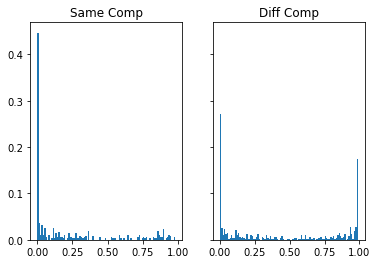

In [251]:
print(np.mean(diffComp),np.mean(sameComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax2.set_title('Diff Comp')

In [230]:
#from matplotlib.pyplot import figure
#figure(figsize=(10, 8), dpi=80)


In [167]:
BigDiffIndices = np.where(disMat.detach().numpy().flatten() > 0.1)[0].tolist()

In [149]:
len(BigDiffIndices)

18906

In [150]:
vizMat = np.zeros([30,30])
vizMat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [152]:
for index in BigDiffIndices:
    row, col = divmod(index,150)
    cat1, cat2 = int(label_np[row]),int(label_np[col])
    #print(cat1,cat2, (cat1 == cat2))
    vizMat[cat1,cat2] += 1
    vizMat[cat2,cat1] += 1


In [153]:
vizMat = vizMat / np.max(vizMat)
vizMat

array([[0.2       , 0.22758621, 0.17586207, 0.62758621, 0.15172414,
        0.2137931 , 0.34137931, 0.37931034, 0.27586207, 0.22068966,
        0.15862069, 0.24482759, 0.36206897, 0.25517241, 0.32413793,
        0.43793103, 0.46206897, 0.1862069 , 0.25862069, 0.30344828,
        0.38275862, 0.47931034, 0.13448276, 0.49310345, 0.44482759,
        0.43103448, 0.31724138, 0.10344828, 0.1862069 , 0.21724138],
       [0.22758621, 0.1862069 , 0.13793103, 0.57931034, 0.12758621,
        0.19655172, 0.30344828, 0.29655172, 0.22068966, 0.16551724,
        0.14827586, 0.21034483, 0.29310345, 0.20689655, 0.24482759,
        0.35172414, 0.34137931, 0.15862069, 0.19655172, 0.25517241,
        0.29310345, 0.37586207, 0.10689655, 0.36896552, 0.36896552,
        0.35517241, 0.25172414, 0.0862069 , 0.18275862, 0.23103448],
       [0.17586207, 0.13793103, 0.04137931, 0.46551724, 0.05517241,
        0.10689655, 0.2       , 0.18965517, 0.11034483, 0.07586207,
        0.06206897, 0.12413793, 0.19655172, 0.

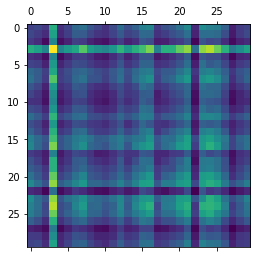

In [154]:
plt.matshow(vizMat)